<a href="https://colab.research.google.com/github/SatyaKuppam/QUBOs-and-Ising-models/blob/master/partitioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install dwave-ocean-sdk

In [0]:
!dwave setup

API KEY DEV-ede183dc09b59568533c926888403f9f50eea422

In [2]:
!dwave ping

Using endpoint: https://cloud.dwavesys.com/sapi/
Using solver: DW_2000Q_6
Submitted problem ID: e79b2860-0829-4e6b-9d42-7963807c9391

Wall clock time:
 * Solver definition fetch: 268.264 ms
 * Problem submit and results fetch: 1303.824 ms
 * Total: 1572.088 ms

QPU timing:
 * anneal_time_per_run = 20 us
 * post_processing_overhead_time = 93 us
 * qpu_access_overhead_time = 819 us
 * qpu_access_time = 10921 us
 * qpu_anneal_time_per_sample = 20 us
 * qpu_delay_time_per_sample = 21 us
 * qpu_programming_time = 10682 us
 * qpu_readout_time_per_sample = 198 us
 * qpu_sampling_time = 239 us
 * readout_time_per_run = 198 us
 * run_time_chip = 239 us
 * total_post_processing_time = 93 us
 * total_real_time = 10921 us


In [0]:
import networkx as nx
import dwave_networkx as dnx
import matplotlib
import matplotlib.pyplot as plt
import dimod
%matplotlib inline

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.cloud import Client
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave_qbsolv import QBSolv
from collections import defaultdict

import networkx as nx
import dwave_networkx as dnx
import neal

## 1. Number Partitioning

* This problem is know to be $NP$-complete.

* The ising model represenatation we consider for number partitioning[1] is $$H = A(\sum_{i=1}^{N}n_is_i)^2$$
* The corresponding QUBO representation is: $$Q = A(\sum_{i=1}^{N}n_i^2q_i-\sum_{i=1}^{N}\sum_{j=1}^{N}n_in_jq_i+2\sum_{1\leq i<j\leq N}n_in_jq_iq_j)$$

* Notice that in the QUBO representation we have disregarded the terms which are independent of $q_i$. Hence the minimum energy will be lower than 0.

* For simplicity of our experimentation we use $A=1$

Lets take the set of numbers of $[1,2,3,4]$ to be split into two sets.
The partition that gives us the least energy is $[1,4]$ and $[2,3]$.


In [0]:
def number_partition(numbers, sampler=None, num_repeats=1000):
  Q = defaultdict(int)

  for i in numbers:
    Q[(i,i)] += i ** 2

  for i in numbers:
    for j in numbers:
      Q[(i,i)] -= i * j

  for idx, number in enumerate(numbers):
    for jdx in range(idx+1,len(numbers)):
      Q[(number,numbers[jdx])] += 2 * number * numbers[jdx]

  return sampler.sample_qubo(Q, num_repeats=num_repeats)

In [0]:
response = number_partition(range(1,5), sampler=QBSolv())
print(response)
print("samples=" + str(list(response.samples())))
print("energies=" + str(list(response.data_vectors['energy'])))

   1  2  3  4 energy num_oc.
0  0  1  1  0  -25.0     494
1  1  0  0  1  -25.0     507
['BINARY', 2 rows, 1001 samples, 4 variables]
samples=[{1: 0, 2: 1, 3: 1, 4: 0}, {1: 1, 2: 0, 3: 0, 4: 1}]
energies=[-25.0, -25.0]


In the above example we could partition the sets into two whose sum of constituent elements in the same. Sometime its not possible to do so.
For example the set $[1,2,3,4,5]$. The partitions whose sum differ by atmost 1 are:

* [1,2,5] and [3,4]
* [1,2,4] and [3,5]
* [1,3,4] and [2,5]

In [0]:
response = number_partition(range(1,6), sampler=QBSolv())
print("samples=" + str(list(response.samples())))
print("energies=" + str(list(response.data_vectors['energy'])))

samples=[{1: 0, 2: 0, 3: 1, 4: 0, 5: 1}, {1: 0, 2: 1, 3: 0, 4: 0, 5: 1}, {1: 1, 2: 0, 3: 1, 4: 1, 5: 0}, {1: 0, 2: 0, 3: 1, 4: 1, 5: 0}, {1: 1, 2: 1, 3: 0, 4: 0, 5: 1}, {1: 1, 2: 1, 3: 0, 4: 1, 5: 0}]
energies=[-56.0, -56.0, -56.0, -56.0, -56.0, -56.0]


In [0]:
def number_partition_bqm(numbers, sampler=None, num_repeats=1000):
  linear, quadratic = defaultdict(int), defaultdict(int)

  for i in numbers:
    linear[i] += i ** 2

  for i in numbers:
    for j in numbers:
      quadratic[(i,i)] -= i * j

  for idx, number in enumerate(numbers):
    for jdx in range(idx+1,len(numbers)):
      quadratic[(number,numbers[jdx])] += 2 * number * numbers[jdx]

  offset = 0.0
  vartype = dimod.BINARY
  bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
  Q, _ = bqm.to_qubo()
  print(bqm.to_qubo())
  return sampler.sample(bqm, num_repeats=num_repeats)

In [0]:
response = number_partition_bqm(range(1,5), sampler=QBSolv())
print(response)
print("samples=" + str(list(response.samples())))
print("energies=" + str(list(response.data_vectors['energy'])))

({(1, 2): 4, (1, 3): 6, (1, 4): 8, (2, 3): 12, (2, 4): 16, (3, 4): 24, (1, 1): -9.0, (2, 2): -16.0, (3, 3): -21.0, (4, 4): -24.0}, 0.0)
   1  2  3  4 energy num_oc.
0  1  0  0  1  -25.0     502
1  0  1  1  0  -25.0     499
['BINARY', 2 rows, 1001 samples, 4 variables]
samples=[{1: 1, 2: 0, 3: 0, 4: 1}, {1: 0, 2: 1, 3: 1, 4: 0}]
energies=[-25.0, -25.0]


## 2. Graph Partitioning

* This problem is a known $NP$-hard problem.

* Given a graph with $N=|V|$ edges partition it into two sets of equal size (i.e $\frac{N}{2}$) such that, the number of edges between the two is minimized.

* From Lucas[1] the ising formulation for this energy function is: 
$$H_A = A(\sum_{i=1}^{N}s_i)^2$$ and $$H_B = B \sum_{(u,v)\in E} \frac{1-s_us_v}{2}$$ and $$H = H_A + H_B$$

* The corresponding QUBO formulation for this problem is: $$Q_A = A[(1-N)\sum_{i=1}^{N}q_i + 2 \sum_{1\leq i <j\leq N} q_iq_j]$$ and $$Q_B = B \sum_{(u,v)\in E}(q_u+q_v-2q_uq_v)$$ and $$Q = Q_A + Q_B$$


* From Lucas[1] we also get the relationship between $A$ and $B$: $$\frac{A}{B}\geq \frac{min(2\Delta,N)}{8}$$

   1  2  3  4 energy num_oc.
0  1  0  0  0   -9.0     517
1  0  0  0  1   -9.0     484
['BINARY', 2 rows, 1001 samples, 4 variables]


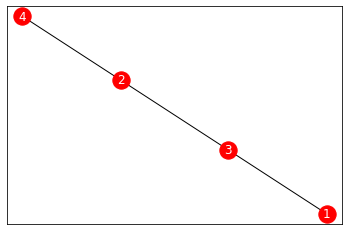

In [7]:
## Define the graph
G = nx.Graph()
G.add_edges_from([(1,3),(3,2),(2,4)])
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, node_list=G.nodes(), pos=pos, node_color='r')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_color='w', font_size=12)

def general_graph_partitioning(G, sampler=None, num_repeats=1000):
  Q = defaultdict(int)

  ## TODO: pass A and B as arguments and raise error when the 
  ##       condition is not satisfied
  A, B = 10, 1
  N = len(G.nodes())

  ## For Q_A
  for node in G.nodes():
    Q[(node, node)] += A * (1-N)

  for node_u in G.nodes():
    for node_v in G.nodes():
      Q[(node_u, node_v)] += 2 * A
     
  ## For Q_B
  for u,v in G.edges():
    Q[(u,u)] += B
    Q[(v,v)] += B
    Q[(u,v)] -= 2 * B

  return sampler.sample_qubo(Q, num_repeats=num_repeats)

print(general_graph_partitioning(G, sampler=QBSolv()))

## Finding Maximal Clique

* Finding the largest clique in a graph is a NP-hard problem, with its decision counter part being a NP-complete problem. We will solve this problem with the ising model from Lucas [1]. However it should be noted that DWave's maximal clique implementation [2], finds the maximal clique by finding the maximum independent set in the complementary graph.


* Say we have a graph $G=(V,E)$, $\Delta$ is the maximum degree of the graph. Lucas [1] implementation uses $2|V|-1$ spins. We define a binary variable $y_i$ which is $1$ for $i$ that is the largest clique and zero otherwise. We also have $x_i$ which is $1$ if the vertex $i$ is in the clique else its $0$.

* The energy function can be divided into three parts $H = H_A + H_B + H_C$.

* $$H_A = A(1 - \sum_{i=2}^{N}y_i)^2 + A(\sum_{i=2}^{N}iy_i - \sum_{v}x_v), \space\space\space\space\space A>0$$ This energy function penalizes choosing more than one value for $y_i$.

* $$H_B = \frac{B}{2}(\sum_{i=2}^{N}iy_i)(\sum_{i=2}^{N}iy_i-1)-B\sum_{(u,v)\in E}x_ux_v, \space\space\space B>0$$ This energy function ensures that we have a clique.

* The ground state is $$H_A=H_B=0$$, with $$A > \Delta B$$.

* $$H_C = -C\sum_{v}x_v$$ which is linearly weighted on the size of the clique. This ensures that we find the largest clique always.

* From Lucas [1] we will choose the value for $A,B,C$ as $A = (\Delta + 2)B$ and $B=C$.



In [0]:
class maximal_clique:
  def __init__(self, G, A=None, B=1.0, C=1.0):
    self.Q = defaultdict(int)
    self.G = G
    self.N = len(G.nodes())
    self.Delta = max(x for _,x in G.degree())
    self.B = B
    self.C = C
    if A is None:
      self.A = (self.Delta + 2) * self.B
    else:
      self.A = A
    self.yidx_start = self.N + 2
    self.yidx_end = 2 * self.N + 1
    print(f"Maximal degree of the graph is {self.Delta}")
    print(f"Setting A {self.A}, B {self.B}, C {self.C}")
    # index for y_i spins
    self.y = self.N + 1

  def energy_function(self):
    return
  
  def _energy_function_h_a(self):
    yidx_start = self.yidx_start
    yidx_end = self.yidx_end

    for i in range(yidx_start, yidx_end):
      for j in range(yidx_start, yidx_end):
        self.Q[(i, j)] += self.A
    
    for i in range(yidx_start, yidx_end):
      self.Q[(i,i)] -= 2 * self.A
    
    for i in range(yidx_start, yidx_end):
      for j in range(yidx_start, yidx_end):
        self.Q[(i, j)] += self.A * (i-self.N) * (j-self.N)
    
    for u in self.G.nodes():
      for v in self.G.nodes():
        self.Q[(u, v)] += self.A
      
    for i in range(yidx_start, yidx_end):
      for u in self.G.nodes():
        self.Q[(i, u)] -= 2 * self.A * (i-self.N)

  def _energy_function_h_b(self):
    yidx_start = self.yidx_start
    yidx_end = self.yidx_end

    for i in range(yidx_start, yidx_end):
      self.Q[(i,i)] -= self.B * 0.5
      for j in range(yidx_start, yidx_end):
        self.Q[(i, j)] += self.B * 0.5 * (i-self.N) * (j-self.N)
    
    for u,v in self.G.edges():
      self.Q[(u, v)] -= self.B

  def _energy_function_h_c(self):
    for node in self.G.nodes():
      self.Q[(node, node)] -= self.C

  def solve(self, solver=None, **kwargs):
    print(self.Q)

    if solver is None:
      print("Setting the solver as QBsolv")
      solver = QBSolv()
  
    return solver.sample_qubo(self.Q, **kwargs)

$H_A$ can be simplified as: $$H_A = A[1+\sum_{i=2}^{N}y_i\sum_{j=2}^{N}y_j-2\sum_{i=2}^{N}y_i]+A[\sum_{i=2}^{N}iy_i\sum_{j=2}^{N}jy_j+\sum_{u}x_u\sum_{v}x_v-2\sum_{i=2}^{N}iy_i\sum_{u}x_u]$$ we will eliminate the constant offset $A$.

Lets define a graph with clique of size three for testing.

1 2
1 3
1 4
2 3


{1: Text(-0.13937506189649132, 0.0423191573222199, '1'),
 2: Text(0.4702606361023699, -0.5004321489839147, '2'),
 3: Text(0.6691144257941213, 0.1544752234635893, '3'),
 4: Text(-1.0, 0.30363776819810534, '4')}

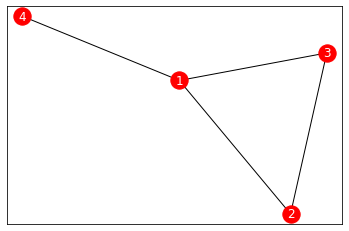

In [26]:
## Define the graph
G_three = nx.Graph()
G_three.add_edges_from([(1,2),(1,3),(1,4), (2,3)])
pos = nx.spring_layout(G_three)

for u,v in G_three.edges():
  print(u,v)

nx.draw_networkx_nodes(G_three, node_list=G_three.nodes(), pos=pos, node_color='r')
nx.draw_networkx_edges(G_three, pos)
nx.draw_networkx_labels(G_three, pos, font_color='w', font_size=12)

Lets first check if $H_A$ works as we predicted. We should have on of the $y_i$ spins marked as 1 and we should have $i$ $x_u$ spins marked as 1.

In [27]:
maximal_clique_solver_three = maximal_clique(G_three)
maximal_clique_solver_three._energy_function_h_a()
maximal_clique_solver_three._energy_function_h_b()
maximal_clique_solver_three._energy_function_h_c()
maximal_clique_solver_three.solve(num_repeats=1000)

Maximal degree of the graph is 3
Setting A 5.0, B 1.0, C 1.0
defaultdict(<class 'int'>, {(6, 6): 16.5, (6, 7): 38.0, (6, 8): 49.0, (7, 6): 38.0, (7, 7): 44.0, (7, 8): 71.0, (8, 6): 49.0, (8, 7): 71.0, (8, 8): 82.5, (1, 1): 4.0, (1, 2): 4.0, (1, 3): 4.0, (1, 4): 4.0, (2, 1): 5.0, (2, 2): 4.0, (2, 3): 4.0, (2, 4): 5.0, (3, 1): 5.0, (3, 2): 5.0, (3, 3): 4.0, (3, 4): 5.0, (4, 1): 5.0, (4, 2): 5.0, (4, 3): 5.0, (4, 4): 4.0, (6, 1): -20.0, (6, 2): -20.0, (6, 3): -20.0, (6, 4): -20.0, (7, 1): -30.0, (7, 2): -30.0, (7, 3): -30.0, (7, 4): -30.0, (8, 1): -40.0, (8, 2): -40.0, (8, 3): -40.0, (8, 4): -40.0})
Setting the solver as QBsolv


SampleSet(rec.array([([1, 1, 1, 0, 0, 1, 0], -7. , 872),
           ([1, 0, 0, 1, 1, 0, 0], -6.5,  36),
           ([0, 1, 1, 0, 1, 0, 0], -6.5,  10),
           ([1, 0, 1, 0, 1, 0, 0], -6.5,  44),
           ([1, 1, 0, 0, 1, 0, 0], -6.5,  43)],
          dtype=[('sample', 'i1', (7,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [1, 2, 3, 4, 6, 7, 8], {}, 'BINARY')

Lets check if $H_B$ works as predicted. This hamiltonian's ground state is when all the nodes are marked as $1$ and all $y_i$ spins are marked as $0$. This shows that $H_B$ without $H_A$ is not of much use.

{1: Text(0.7882513624541124, 1.0, '1'),
 2: Text(-0.7882513624545904, -0.9999999999996237, '2'),
 3: Text(0.9981440883234822, -0.7867884375468892, '3'),
 4: Text(-0.9981440883230056, 0.7867884375465133, '4')}

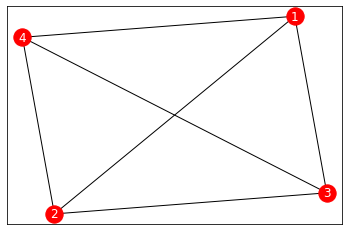

In [19]:
## Define the graph
G_four_fully_connected = nx.Graph()
G_four_fully_connected.add_edges_from([(1,2),(1,3),(1,4), (2,4), (3,4), (2,3)])
pos = nx.spring_layout(G_four_fully_connected)

nx.draw_networkx_nodes(G_four_fully_connected, node_list=G_four_fully_connected.nodes(), pos=pos, node_color='r')
nx.draw_networkx_edges(G_four_fully_connected, pos)
nx.draw_networkx_labels(G_four_fully_connected, pos, font_color='w', font_size=12)

In [28]:
maximal_clique_solver_four_fully_connected = maximal_clique(G_four_fully_connected)
maximal_clique_solver_four_fully_connected._energy_function_h_a()
maximal_clique_solver_four_fully_connected._energy_function_h_b()
maximal_clique_solver_four_fully_connected._energy_function_h_c()
maximal_clique_solver_four_fully_connected.solve(num_repeats=1000)

Maximal degree of the graph is 3
Setting A 5.0, B 1.0, C 1.0
defaultdict(<class 'int'>, {(6, 6): 16.5, (6, 7): 38.0, (6, 8): 49.0, (7, 6): 38.0, (7, 7): 44.0, (7, 8): 71.0, (8, 6): 49.0, (8, 7): 71.0, (8, 8): 82.5, (1, 1): 4.0, (1, 2): 4.0, (1, 3): 4.0, (1, 4): 4.0, (2, 1): 5.0, (2, 2): 4.0, (2, 3): 4.0, (2, 4): 4.0, (3, 1): 5.0, (3, 2): 5.0, (3, 3): 4.0, (3, 4): 4.0, (4, 1): 5.0, (4, 2): 5.0, (4, 3): 5.0, (4, 4): 4.0, (6, 1): -20.0, (6, 2): -20.0, (6, 3): -20.0, (6, 4): -20.0, (7, 1): -30.0, (7, 2): -30.0, (7, 3): -30.0, (7, 4): -30.0, (8, 1): -40.0, (8, 2): -40.0, (8, 3): -40.0, (8, 4): -40.0})
Setting the solver as QBsolv


SampleSet(rec.array([([1, 1, 1, 1, 0, 0, 1], -7.5, 588),
           ([1, 1, 1, 0, 0, 1, 0], -7. ,  93),
           ([0, 1, 1, 1, 0, 1, 0], -7. , 113),
           ([1, 0, 1, 1, 0, 1, 0], -7. , 106),
           ([1, 1, 0, 1, 0, 1, 0], -7. , 105)],
          dtype=[('sample', 'i1', (7,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [1, 2, 3, 4, 6, 7, 8], {}, 'BINARY')

The following graph has two cliques, where one clique is larger than the other.

{1: Text(0.0020244180145235, 0.0952223150625972, '1'),
 2: Text(0.38823981629679255, -0.5830949396704713, '2'),
 3: Text(-0.0198246537298921, -0.9324942056028345, '3'),
 4: Text(-0.4126706159965689, -0.5660676703094866, '4'),
 5: Text(0.34015618558329747, 0.9864345005201948, '5'),
 6: Text(-0.29792515016815285, 1.0, '6')}

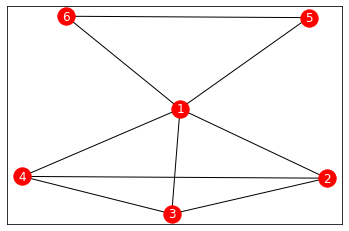

In [23]:
## Define the graph
G_two_cliques = nx.Graph()
G_two_cliques.add_edges_from([(1,2),(1,3),(1,4), (2,4), (3,4), (2,3), (1,5), (5,6), (6,1)])
pos = nx.spring_layout(G_two_cliques)

nx.draw_networkx_nodes(G_two_cliques, node_list=G_two_cliques.nodes(), pos=pos, node_color='r')
nx.draw_networkx_edges(G_two_cliques, pos)
nx.draw_networkx_labels(G_two_cliques, pos, font_color='w', font_size=12)

In [29]:
maximal_clique_solver_two_cliques = maximal_clique(G_two_cliques)
maximal_clique_solver_two_cliques._energy_function_h_a()
maximal_clique_solver_two_cliques._energy_function_h_b()
maximal_clique_solver_two_cliques._energy_function_h_c()
maximal_clique_solver_two_cliques.solve(num_repeats=1000)

Maximal degree of the graph is 5
Setting A 7.0, B 1.0, C 1.0
defaultdict(<class 'int'>, {(8, 8): 22.5, (8, 9): 52.0, (8, 10): 67.0, (8, 11): 82.0, (8, 12): 97.0, (9, 8): 52.0, (9, 9): 60.0, (9, 10): 97.0, (9, 11): 119.5, (9, 12): 142.0, (10, 8): 67.0, (10, 9): 97.0, (10, 10): 112.5, (10, 11): 157.0, (10, 12): 187.0, (11, 8): 82.0, (11, 9): 119.5, (11, 10): 157.0, (11, 11): 180.0, (11, 12): 232.0, (12, 8): 97.0, (12, 9): 142.0, (12, 10): 187.0, (12, 11): 232.0, (12, 12): 262.5, (1, 1): 6.0, (1, 2): 6.0, (1, 3): 6.0, (1, 4): 6.0, (1, 5): 6.0, (1, 6): 6.0, (2, 1): 7.0, (2, 2): 6.0, (2, 3): 6.0, (2, 4): 6.0, (2, 5): 7.0, (2, 6): 7.0, (3, 1): 7.0, (3, 2): 7.0, (3, 3): 6.0, (3, 4): 6.0, (3, 5): 7.0, (3, 6): 7.0, (4, 1): 7.0, (4, 2): 7.0, (4, 3): 7.0, (4, 4): 6.0, (4, 5): 7.0, (4, 6): 7.0, (5, 1): 7.0, (5, 2): 7.0, (5, 3): 7.0, (5, 4): 7.0, (5, 5): 6.0, (5, 6): 6.0, (6, 1): 7.0, (6, 2): 7.0, (6, 3): 7.0, (6, 4): 7.0, (6, 5): 7.0, (6, 6): 6.0, (8, 1): -28.0, (8, 2): -28.0, (8, 3): -28.0, (8, 4

SampleSet(rec.array([([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0], -9.5, 221),
           ([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0], -9. , 168),
           ([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0], -9. , 184),
           ([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], -9. ,  32),
           ([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0], -9. ,  75),
           ([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0], -9. ,  52),
           ([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0], -8.5,  29),
           ([0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0], -8.5,  21),
           ([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], -8.5, 107),
           ([1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0], -8.5,  17),
           ([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], -8.5,  19),
           ([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], -8.5,  27),
           ([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], -8.5,  21),
           ([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0], -8.5,  15),
           ([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], -8.5,  29),
           ([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0], -8. ,   3),
           ([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],

The Dwave BQM version of the QUBO above. In this representation we also add the contant offset $A$ in $H_A$.

In [0]:
class maximal_clique_bqm:
  def __init__(self, G, solver=None, A=None, B=1.0, C=1.0):
    self.Q = defaultdict(int)
    self.G = G
    self.solver = solver
    self.N = len(G.nodes())
    self.Delta = max(x for _,x in G.degree())
    self.B = B
    self.C = C
    if A is None:
      self.A = (self.Delta + 2) * self.B
    else:
      self.A = A
    self.yidx_start = self.N + 2
    self.yidx_end = 2 * self.N + 1
    print(f"Maximal degree of the graph is {self.Delta}")
    print(f"Setting A {self.A}, B {self.B}, C {self.C}")
    # index for y_i spins
    self.y = self.N + 1
    self.linear = defaultdict(int)
    self.quadratic = defaultdict(int)
    self.vartype = dimod.BINARY
    self.offset = 0.0

    if solver is None:
      print("Setting the solver as QBsolv")
      self.solver = QBSolv()

  def _energy_function_h_c(self):
    for u in self.G.nodes():
      self.linear[u] -= self.C

  def _energy_function_h_b(self):
    yidx_start = self.yidx_start
    yidx_end = self.yidx_end

    for i in range(yidx_start, yidx_end):
      self.linear[i] += self.B * 0.5 * (i - self.N) * (i - self.N - 1)

    for u,v in self.G.edges():
      self.quadratic[(u, v)] -= self.B 

  def _energy_function_h_a(self):
    yidx_start = self.yidx_start
    yidx_end = self.yidx_end

    self.offset += self.A
    for i in range(yidx_start, yidx_end):
      for j in range(yidx_start, yidx_end):
        self.quadratic[(i, j)] += self.A
    
    for i in range(yidx_start, yidx_end):
      self.linear[i] -= 2 * self.A
    
    for i in range(yidx_start, yidx_end):
      for j in range(yidx_start, yidx_end):
        self.quadratic[(i, j)] += self.A * (i-self.N) * (j-self.N)
    
    for u in self.G.nodes():
      for v in self.G.nodes():
        self.quadratic[(u, v)] += self.A
      
    for i in range(yidx_start, yidx_end):
      for u in self.G.nodes():
        self.quadratic[(i, u)] -= 2 * self.A * (i-self.N)
    
  def solve(self, num_repeats=1000):
    bqm = dimod.BinaryQuadraticModel(self.linear, self.quadratic, self.offset, self.vartype)
    return self.solver.sample(bqm, num_repeats=num_repeats)

1 2
1 3
1 4
2 3


{1: Text(0.07868941768603659, 0.139306805717981, '1'),
 2: Text(0.004439414921075297, -0.7539226989295631, '2'),
 3: Text(-0.6479964552450046, -0.3853841067884178, '3'),
 4: Text(0.5648676226378926, 1.0, '4')}

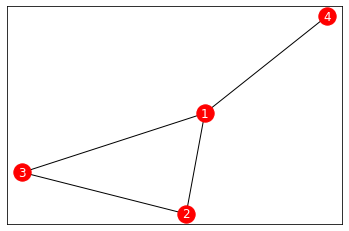

In [44]:
## Define the graph
G_three = nx.Graph()
G_three.add_edges_from([(1,2),(1,3),(1,4), (2,3)])
pos = nx.spring_layout(G_three)

for u,v in G_three.edges():
  print(u,v)

nx.draw_networkx_nodes(G_three, node_list=G_three.nodes(), pos=pos, node_color='r')
nx.draw_networkx_edges(G_three, pos)
nx.draw_networkx_labels(G_three, pos, font_color='w', font_size=12)

In [45]:
maximal_clique_solver_three = maximal_clique_bqm(G_three)
maximal_clique_solver_three._energy_function_h_a()
maximal_clique_solver_three._energy_function_h_b()
maximal_clique_solver_three._energy_function_h_c()
maximal_clique_solver_three.solve(num_repeats=10000)

Maximal degree of the graph is 3
Setting A 5.0, B 1.0, C 1.0
Setting the solver as QBsolv


SampleSet(rec.array([([1, 1, 1, 0, 0, 1, 0], -3., 7974),
           ([1, 0, 1, 0, 1, 0, 0], -2.,  409),
           ([1, 1, 0, 1, 0, 1, 0], -2.,   61),
           ([1, 0, 0, 1, 1, 0, 0], -2.,  344),
           ([1, 1, 0, 0, 1, 0, 0], -2.,  429),
           ([1, 0, 1, 1, 0, 1, 0], -2.,   60),
           ([0, 1, 1, 0, 1, 0, 0], -2.,  730)],
          dtype=[('sample', 'i1', (7,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), [1, 2, 3, 4, 6, 7, 8], {}, 'BINARY')

### TODO:
* Example with $log(N)$ auxiliary spins instead of $N$ as shown in Lucas.
* Example with DWave QPU
* Solve all the above problems with Trotterization

## References

[1] Lucas, Andrew. "Ising formulations of many NP problems." Frontiers in Physics 2 (2014): 5.

[2] DWave largest clique: https://docs.ocean.dwavesys.com/projects/dwave-networkx/en/latest/_modules/dwave_networkx/algorithms/clique.html